# Решение задачи распознавания символов с использованием свёрточной нейронной сети

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image as img
from matplotlib import pyplot as plt
%matplotlib notebook

/home/ksg/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Для увеличения производительности введём два массива. $symbols$ для получения символа по номеру, и обратный разреженный массив(из-за быстродействия используем обычный массив заполненный участками).

In [4]:
symbols = [chr(ord('0')+i) for i in range(0,10)]
buf = "A"
while buf.isalpha():
    symbols.append(buf)
    buf = chr(ord(buf)+1)
    
buf = "a"
while buf.isalpha():
    symbols.append(buf)
    buf = chr(ord(buf)+1)

In [5]:
inverse_symbols = np.empty(shape = [256,])
inverse_symbols[:] = None
for ind,i in enumerate(symbols):
    inverse_symbols[ord(i)] = ind

Загружаем данные об изображениях в имеющейся выборке.

In [6]:
dataframe = pd.read_csv('Data/trainLabels.csv')


Создадим функцию которая по id изображения будет возвращать его представление в виде трёхмерного массива.

In [7]:
datapath = "Data/archives/trainResized/"
def get_arr_by_id(id):
    buf = np.asarray(img.open(datapath+"{}.Bmp".format(str(id))))
    if buf.shape == (20,20):
        buf = np.concatenate([buf.reshape(20,20,1),]*3,axis=2)
    return buf

In [8]:
sess = tf.InteractiveSession()
classnum = 62
x = tf.placeholder(tf.float32, shape=[None, 1200])
y_ = tf.placeholder(tf.float32, shape=[None, classnum])

Функции-обёртки для чистоты кода

In [9]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.00005, dtype=tf.float32)  
  #mean = -987
  #th = 0.000001
  #initial = tf.random_uniform(shape, minval=(mean-th), maxval=(mean+th))
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def max_pool_1x1(x):
  return tf.nn.max_pool(x, ksize=[1, 1, 1, 1],
                        strides=[1, 1, 1, 1], padding='SAME')


Первый свёрточный слой из 16 фильтров. 
Часть параметров были выбраны исходя из возможности системы. 

In [10]:
filtersnum = 16
W_conv1 = weight_variable([5, 5, 3, filtersnum])
b_conv1 = bias_variable([filtersnum])
x_image = tf.reshape(x, [-1,20,20,3])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

Первый свёрточный слой проходит без пула. 
Второй свёрточный слой содержит в себе 32 фильтра меньшего размера. 

In [11]:
filtersnum2l = 32
W_conv2 = weight_variable([3, 3, filtersnum, filtersnum2l])
b_conv2 = bias_variable([filtersnum2l])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Третий свёрточный слой с бОльшим количеством фильтров.

In [12]:
filtersnum3l = 64
W_conv3 = weight_variable([3, 3, filtersnum2l, filtersnum3l])
b_conv3 = bias_variable([filtersnum3l])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

Четвёртый слой представляет сообой обыкновенный relu слой. 

In [13]:
neyronsize = 2048
W_fc1 = weight_variable([5 * 5 * filtersnum3l, neyronsize])
b_fc1 = bias_variable([neyronsize])

In [14]:
h_pool3_flat = tf.reshape(h_pool3, [-1, 5*5*filtersnum3l])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

Выходной слой.

Вводим тензоры ентропии и точности. Были опробованы два метода оптимизации, обычному градиентному спуску оказался предпочтительней AdamOptimizer. Что будет объяснено ниже.

In [15]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([neyronsize, classnum])
b_fc2 = bias_variable([classnum])
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [16]:
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), reduction_indices=[1]))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy)
#train_step = tf.train.GradientDescentOptimizer(0.00001).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

Функции перевода символа ASCII в нашу нумерацию и обратно.

In [17]:
def get_num_by_symb(symb):
    return int(inverse_symbols[ord(symb)])
def get_symb_by_num(num):
    return symbols[num]

Функции загрузки всех данных указанных во фрейме. Разбиение изначального фрейма на тренировочный и тестовый. И разбиение тестового на более мелкие участки для бОльшей производительности.

In [18]:
def load_data(frame):
    x = np.empty(shape=[0,1200])
    y_ = np.empty(shape=[0,classnum])
    for i in frame.iterrows():
        x = np.concatenate([x,np.array([get_arr_by_id(i[1]["ID"]),]).reshape([1,1200]),])
        ans = np.zeros(shape = [classnum,])
        ind = get_num_by_symb(i[1]["Class"])
        ans[ind] = 1
        y_ = np.concatenate([y_,[ans,]])
    return x,y_
#_x, _y_ = load_data(dataframe)
#print(len(_x))
#print(len(_y_))
dataframe_test = dataframe.tail(628)
dataframe_train = dataframe.head(len(dataframe.index)-628)
batchesize = 61
frames = []
buf = dataframe_train
while not buf.empty:
    frames.append(buf.head(batchesize))
    buf = buf.tail(len(buf.index) - batchesize)

Обёртки для динамической отрисовки графиков 

In [19]:
accplot = None
entrplot = None
def init_plots():
    global accplot, entrplot
    accplot,ac = plt.subplots(1,1)
    #ac, = accplot.axes
    ac.set_xlabel('step')
    ac.set_ylabel('accuracy')
    ac.plot([],[])
    ac.plot([],[])
    entrplot,ac = plt.subplots(1,1)
    #ac, = entrplot.axes
    ac.set_xlabel('step')
    ac.set_ylabel('entropy')
    ac.plot([],[])
    ac.plot([],[])

def update_plots(step, acc, entr,acc2,entr2):
    global accplot, entrplot
    liner = entrplot.axes[0].lines[0]
    ax = entrplot.axes[0]
    x = np.append(liner.get_xdata(), step)
    y = np.append(liner.get_ydata(), entr)
    
    liner = entrplot.axes[0].lines[1]
    ax = entrplot.axes[0]
    x2 = np.append(liner.get_xdata(), step)
    y2 = np.append(liner.get_ydata(), entr2)
    #print(x,y)
    ax.clear()
    ax.plot(x,y)
    ax.plot(x2,y2)
    entrplot.canvas.draw()
    
    liner = accplot.axes[0].lines[0]
    ax = accplot.axes[0]
    x = np.append(liner.get_xdata(), step)
    y = np.append(liner.get_ydata(), acc)
    liner = accplot.axes[0].lines[1]
    ax = accplot.axes[0]
    x2 = np.append(liner.get_xdata(), step)
    y2 = np.append(liner.get_ydata(), acc2)
    #print(x,y)
    ax.clear()
    ax.plot(x,y)
    ax.plot(x2,y2)
    accplot.canvas.draw()

Обёртка для загрузки графиков

In [20]:
import pickle
def load_plots():
    global accplot, entrplot
    liner = entrplot.axes[0].lines[0]
    ax = entrplot.axes[0]
    x,y = None,None
    with open('xfile_acc_train') as f:
        x = pickle.load(f)
    with open('yfile_acc_train') as f:
        y = pickle.load(f)
    
    liner = entrplot.axes[0].lines[1]
    ax = entrplot.axes[0]
    x2,y2 = None,None
    with open('xfile_acc_test') as f:
        x2 = pickle.load(f)
    with open('yfile_acc_test') as f:
        y2 = pickle.load(f)
    #print(x,y)
    ax.clear()
    ax.plot(x,y)
    ax.plot(x2,y2)
    entrplot.canvas.draw()
    
    liner = accplot.axes[0].lines[0]
    ax = accplot.axes[0]
    x,y = None,None
    with open('xfile_entr_train') as f:
        x = pickle.load(f)
    with open('yfile_entr_train') as f:
        y = pickle.load(f)
    x2,y2 = None,None
    with open('xfile_entr_test') as f:
        x2 = pickle.load(f)
    with open('yfile_entr_test') as f:
        y2 = pickle.load(f)
    ax.clear()
    ax.plot(x,y)
    ax.plot(x2,y2)
    accplot.canvas.draw()

Процесс обучения на частях данных. Через каждые сто итераций части перемешиваются для большей точности. В процессе сохраняются результаты оптимизатора. (закомментировал строки для загрузки сохранённых результатов) Проблема системы заключается в продолжительном плато в начале, с которым градиентный спуск не справляется, но Adam, продолжает обучение, пусть и через очень большое количество итераций. На выбранной тестовой выборке была достигнута точность выше 50 процентов. Большей точности достигнуть не удалось из-за ограниченности в ресурсах. 

Остановка обучения происходит вручную, путём визуального анализа графика. Состояние давшее наилучший результат сохраняется автоматически. К такому методу решено было прибегнуть из-за свойств графика. 

<IPython.core.display.Javascript object>


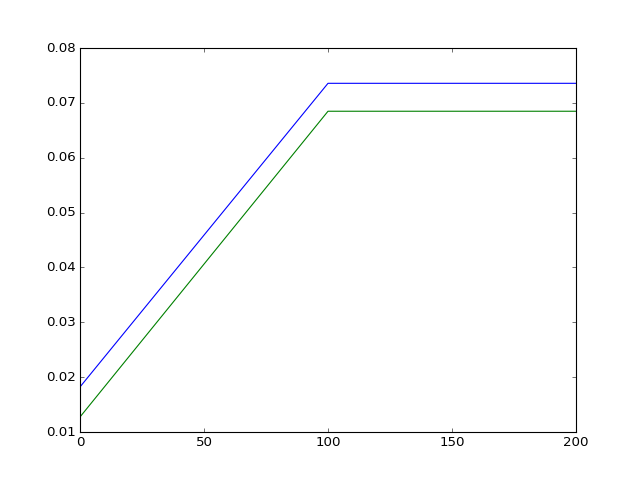

<IPython.core.display.Javascript object>


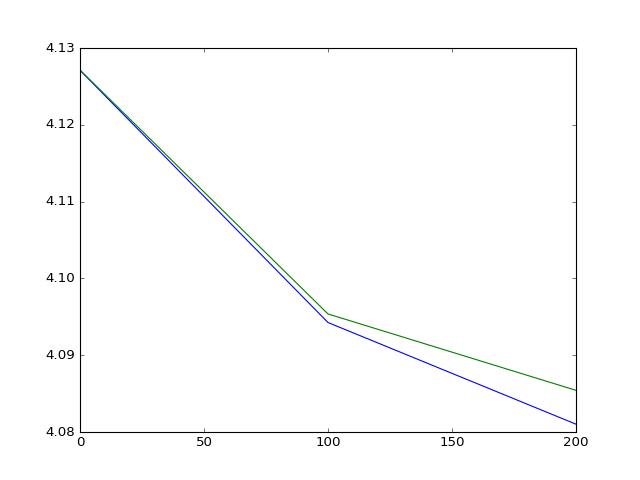

KeyboardInterrupt: 

In [25]:
import random
init_plots()
#load_plots()
xt,yt = load_data(dataframe_train)
all_vars = tf.all_variables()
saver = tf.train.Saver(all_vars)
#saver.restore(sess,'model2-88000')
x_test,y_test = load_data(dataframe_test)
#print(tf.trainable_variables())
max_accur = 0 
for i in range(300000):
    xit, yit = load_data(frames[i%len(frames)])
    if (i%100) == 0:
        train_accuracy = accuracy.eval(feed_dict={x: xt, y_: yt, keep_prob: 0.5})
        train_cross_entropy = cross_entropy.eval(feed_dict={x: xt, y_: yt, keep_prob: 0.5})
        test_accuracy = accuracy.eval(feed_dict={x: x_test, y_: y_test, keep_prob: 0.5})
        test_cross_entropy = cross_entropy.eval(feed_dict={x: x_test, y_: y_test, keep_prob: 0.5})
        update_plots(i,train_accuracy, train_cross_entropy,test_accuracy, test_cross_entropy)
        #print("step %d, training accuracy %g"%(i, train_accuracy))
        random.shuffle(frames)
        if (i%1000) == 0:
            saver.save(sess,'model2',global_step = i)
            if test_accuracy > max_accur:
                 saver.save(sess,'max_accur')
            
    train_step.run(feed_dict={x: xit, y_: yit, keep_prob: 0.5})

Ручное сохранение последней итерации.

In [ ]:
saver.save(sess,'model',global_step = 300000)

Ручное сохранение графиков.

In [24]:
import pickle
def dumpergr():
    global accplot, entrplot
    liner = entrplot.axes[0].lines[0]
    ax = entrplot.axes[0]
    x = liner.get_xdata()
    y = liner.get_ydata()
    with open('xfile_acc_train','wb') as f:
        pickle.dump(x, f)
    with open('yfile_acc_train','wb') as f:
        pickle.dump(y, f)
        
    liner = entrplot.axes[0].lines[1]
    ax = entrplot.axes[0]
    x2 = liner.get_xdata()
    y2 = liner.get_ydata()
    with open('xfile_acc_test','wb') as f:
        pickle.dump(x2, f)
    with open('yfile_acc_test','wb') as f:
        pickle.dump(y2, f)

    liner = accplot.axes[0].lines[0]
    ax = accplot.axes[0]
    x = liner.get_xdata()
    y = liner.get_ydata()
    with open('xfile_entr_train','wb') as f:
        pickle.dump(x, f)
    with open('yfile_entr_train','wb') as f:
        pickle.dump(y, f)
    liner = accplot.axes[0].lines[1]
    ax = accplot.axes[0]
    x2 = liner.get_xdata()
    y2 = liner.get_ydata()
    with open('xfile_entr_test','wb') as f:
        pickle.dump(x2, f)
    with open('yfile_entr_test','wb') as f:
        pickle.dump(y2, f)
dumpergr()

### Вывод
Из-за недостатка ресурсов не удалось в должной мере исследовать параметры. Была достигнута дочность в 50+%, далее началось переобучение. 

# Тест
Прежде всего изменим, datapath. И загрузим новый dataframe.

In [23]:
datapath = "Data/archives/testResized/"
dataframe = pd.read_csv("Data/sampleSubmission.csv")

Загрузим результаты предыдущих запусков.

In [26]:
all_vars = tf.all_variables()
saver = tf.train.Saver(all_vars)
saver.restore(sess,'max_accur')

In [48]:
label = tf.argmax(y_conv,1)
x_t, y_t = load_data(dataframe)

In [51]:
lbl = label.eval(feed_dict={x: x_t, y_: y_t, keep_prob: 0.5})
#for xit,yit,dfit in zip(x_t,y_t, dataframe.iterrows()):    
#    dfit[1]["Class"] = lbl

In [62]:
for i,lbli in zip(dataframe.iterrows(),lbl):
    dataframe.set_value(i[0],"Class", get_symb_by_num(lbli))

In [63]:
dataframe.to_csv("My.csv")